In [1]:
import numpy
import sys
import os
from cStringIO import StringIO
import matplotlib.pyplot as plt

import gym

sys.path.append(os.path.abspath('./evolutionary-optimization/src'))
import OptimizerFactory

## Cart Pole

In [2]:
env = gym.make('CartPole-v0')
print(env.action_space)
print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)

num_params = len(env.observation_space.high)
population_size = 5
num_iterations = 3

Discrete(2)
Box(4,)
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


### Random policy

In [3]:
def random_run(render=True, trials=20):
    bestreward = -float('inf')
    for i_trial in range(trials):
        observation = env.reset()
        totalreward = 0
        for t in xrange(sys.maxint):

            action = env.action_space.sample()
            observation, reward, done, info = env.step(action)

            if render:
                env.render()

            totalreward += reward
            if done:
                print("Trial ended at {} time steps".format(t + 1))
                break
        if totalreward > bestreward:
            bestreward = totalreward
    return bestreward

In [4]:
random_run(render=True, trials=1)

Trial ended at 14 time steps


14.0

In [5]:
random_run(render=False, trials=population_size * num_iterations)

Trial ended at 9 time steps
Trial ended at 19 time steps
Trial ended at 14 time steps
Trial ended at 19 time steps
Trial ended at 18 time steps
Trial ended at 23 time steps
Trial ended at 14 time steps
Trial ended at 17 time steps
Trial ended at 14 time steps
Trial ended at 26 time steps
Trial ended at 10 time steps
Trial ended at 19 time steps
Trial ended at 58 time steps
Trial ended at 17 time steps
Trial ended at 34 time steps


58.0

### EA policies

In [6]:
def run_trial(parameters):
    observation = env.reset()
    totalreward = 0
    while True:
        
        # transformation from optimization solution (rl agent) to action
        action = 0 if numpy.matmul(parameters, observation) < 0 else 1

        observation, reward, done, info = env.step(action)
        totalreward += reward
        if done:
            break
    return totalreward

def objective_function(parameters):
    assert len(parameters) == num_params
    return run_trial(parameters)

def ea(option):
    assert option in ['pso', 'ga', 'dea']
    optimizer = OptimizerFactory.create(
        option=option,
        param_count=num_params,
    )
    optimizer.optimizer.population_size = population_size
    optimizer.optimizer.max_iterations = num_iterations
    best_params = optimizer.maximize(objective_function)
    best_fitness = objective_function(best_params)
    return best_fitness

def sp(option):
    assert option in ['nm', 'bfgs', 'pow', 'bh', 'sdea']
    optimizer = OptimizerFactory.create(
        option=option,
        param_count=num_params,
    )
    best_params = optimizer.maximize(objective_function)
    best_fitness = objective_function(best_params)
    return best_fitness


In [7]:
ea('pso')

#
# 2018-10-30 19:45:27.136012
#
# algorithm            = _PSOptimizer
# timeout              = None
# max_iterations       = 3
# population_size      = 5
# max_initial_velocity = 0.02
# omega                = 0.9
# phi_particle         = 0.3
# phi_swarm            = 0.1
#
# PARTICLES FOR ITERATION 1
# swarm_fitness           = 200.0
# best_average_fitness    = 70.8
# best_minimum_fitness    = 8.0
# best_maximum_fitness    = 200.0
# current_average_fitness = 70.8
# current_minimum_fitness = 8.0
# current_maximum_fitness = 200.0
#
# gen idv              fitness               param0               param1               param2               param3         best_fitness          best-param0          best-param1          best-param2          best-param3
    1   0         200.00000000           0.14224674           0.18564021           0.67393474           0.84935154         200.00000000           0.14224674           0.18564021           0.67393474           0.84935154
    1   1          58.00

200.0

In [8]:
def comp(options=['rand', 'nm', 'bfgs', 'pow', 'bh', 'sdea', 'pso', 'ga', 'dea']):

    # obsorb standard output, mystdout.getvalue()
    old_stdout = sys.stdout
    sys.stdout = mystdout = StringIO() 
    
    to_plot = [[] for _ in options]
    repeats = 3
    
    for i, option in enumerate(options):
        for _ in range(repeats):
            if option == 'rand':
                to_plot[i].append(random_run(render=False))
            elif option in ['nm', 'bfgs', 'pow', 'bh', 'sdea']:
                to_plot[i].append(sp(option))
            elif option in ['pso', 'ga', 'dea']:
                to_plot[i].append(ea(option))
            else:
                assert False
        
    sys.stdout = old_stdout
    
    plt.boxplot(to_plot)
    plt.ylabel('objective for maximization')
    plt.xticks(range(1, len(options) + 1), options)

/Users/jade/Documents/Strong/side-projects/ea-rl/venv/lib/python2.7/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/Users/jade/Documents/Strong/side-projects/ea-rl/venv/lib/python2.7/site-packages/scipy/optimize/_differentialevolution.py:603: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


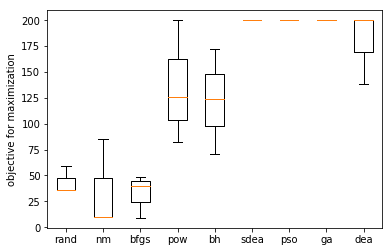

In [9]:
comp()

## Pendulum

In [10]:
env = gym.make('Pendulum-v0')
print(env.action_space)
print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)

mid_dim = 1
num_params = \
    env.observation_space.shape[0] * mid_dim + \
    mid_dim * env.action_space.shape[0]

population_size = 100
num_iterations = 10

Box(1,)
Box(3,)
[1. 1. 8.]
[-1. -1. -8.]


In [11]:
random_run(render=True, trials=1)

Trial ended at 200 time steps


-1684.3996920787592

In [12]:
def run_trial(weights):
    observation = env.reset()
    totalreward = 0
    while True:
        
        # transformation from optimization solution (rl agent) to action
        tmp = numpy.dot(observation, weights[0])
        action = numpy.dot(tmp, weights[1])

        observation, reward, done, info = env.step(action)
        totalreward += reward
        if done:
            break
    return totalreward

def params2weights(parameters):
    assert len(parameters) == num_params
    weights = [
        numpy.zeros(shape=(env.observation_space.shape[0], mid_dim)),
        numpy.zeros(shape=(mid_dim, env.action_space.shape[0]))
    ]
    index = 0
    for i in xrange(env.observation_space.shape[0]):
        for j in xrange(mid_dim):
            weights[0][i, j] = parameters[index]
            index += 1
    for i in xrange(mid_dim):
        for j in xrange(env.action_space.shape[0]):
            weights[1][i, j] = parameters[index]
            index += 1
    return weights

def objective_function(parameters):
    assert len(parameters) == num_params
    weights = params2weights(parameters)
    return run_trial(weights)


In [13]:
ea('dea')

#
# 2018-10-30 19:45:56.254456
#
# algorithm             = _DEAOptimizer
# timeout               = None
# max_iterations        = 10
# population_size       = 100
# crossover_probability = 0.5
# differential_weight   = 1.0
#
# POPULATION FOR GENERATION 1
# average_fitness = -1413.06351185
# min_fitness     = -1788.44818001
# max_fitness     = -872.048407052
#
# gen idv              fitness               param0               param1               param2               param3
    1   1        -872.04840705           0.07695658           0.48031830           0.10108814           0.19349788
    1   2        -901.55710294           0.30242500           0.61203869           0.06863366           0.74255688
    1   3        -904.88135036           0.69652873           0.32279978           0.21017177           0.10761765
    1   4        -906.70079093           0.55654190           0.26894005           0.41989000           0.04144167
    1   5        -913.06235503           0.20011980           0

#
# POPULATION FOR GENERATION 2
# average_fitness = -1290.97538243
# min_fitness     = -1656.53922955
# max_fitness     = -747.259931384
#
# gen idv              fitness               param0               param1               param2               param3
    2   1        -747.25993138           0.65666468           0.44239677           0.10058583          -0.03278544
    2   2        -758.90301445           2.61072831           1.51449050           0.16893001           0.59851619
    2   3        -770.68241725           0.43008735          -0.57666544           0.22001924           0.01344386
    2   4        -862.08386470          -0.19261087           0.13005045           0.01578399           0.18101117
    2   5        -872.04840705           0.07695658           0.48031830           0.10108814           0.19349788
    2   6        -873.38590834           1.46028123           0.93391741           0.07996296           0.28042384
    2   7        -874.52736135           0.96873248     

#
# POPULATION FOR GENERATION 3
# average_fitness = -1261.7368485
# min_fitness     = -1612.60730924
# max_fitness     = -747.259931384
#
# gen idv              fitness               param0               param1               param2               param3
    3   1        -747.25993138           0.65666468           0.44239677           0.10058583          -0.03278544
    3   2        -758.90301445           2.61072831           1.51449050           0.16893001           0.59851619
    3   3        -770.68241725           0.43008735          -0.57666544           0.22001924           0.01344386
    3   4        -862.08386470          -0.19261087           0.13005045           0.01578399           0.18101117
    3   5        -867.20944565           0.08845371           0.86561381           0.00889708           0.80387111
    3   6        -872.04840705           0.07695658           0.48031830           0.10108814           0.19349788
    3   7        -873.38590834           1.46028123      

#
# POPULATION FOR GENERATION 4
# average_fitness = -1215.53488773
# min_fitness     = -1605.70738602
# max_fitness     = -625.534733306
#
# gen idv              fitness               param0               param1               param2               param3
    4   1        -625.53473331           0.81193603           0.15823239           0.01578399           0.12092738
    4   2        -674.68570680          -1.41811589           0.89931498           0.22001924           0.01344386
    4   3        -747.25993138           0.65666468           0.44239677           0.10058583          -0.03278544
    4   4        -747.83764431           0.66209683           2.23887155           0.04871267           0.26368427
    4   5        -758.90301445           2.61072831           1.51449050           0.16893001           0.59851619
    4   6        -763.34478094           0.92976368           0.93391741           0.07996296           1.21915341
    4   7        -867.20944565           0.08845371     

#
# POPULATION FOR GENERATION 5
# average_fitness = -1159.91283133
# min_fitness     = -1605.70738602
# max_fitness     = -586.229185314
#
# gen idv              fitness               param0               param1               param2               param3
    5   1        -586.22918531          -0.43173264           0.80380499           0.01301519           0.47173720
    5   2        -624.78264152          -0.22869374           1.65756991           0.12911442           0.55524977
    5   3        -625.53473331           0.81193603           0.15823239           0.01578399           0.12092738
    5   4        -674.68570680          -1.41811589           0.89931498           0.22001924           0.01344386
    5   5        -747.25993138           0.65666468           0.44239677           0.10058583          -0.03278544
    5   6        -747.83764431           0.66209683           2.23887155           0.04871267           0.26368427
    5   7        -758.90301445           2.61072831     

#
# POPULATION FOR GENERATION 6
# average_fitness = -1090.8311084
# min_fitness     = -1601.53211303
# max_fitness     = -586.229185314
#
# gen idv              fitness               param0               param1               param2               param3
    6   1        -586.22918531          -0.43173264           0.80380499           0.01301519           0.47173720
    6   2        -624.78264152          -0.22869374           1.65756991           0.12911442           0.55524977
    6   3        -625.53473331           0.81193603           0.15823239           0.01578399           0.12092738
    6   4        -674.68570680          -1.41811589           0.89931498           0.22001924           0.01344386
    6   5        -674.71125456          -0.74377797           0.00736888           0.21007734           0.01859127
    6   6        -747.25993138           0.65666468           0.44239677           0.10058583          -0.03278544
    6   7        -747.83764431           0.66209683      

#
# POPULATION FOR GENERATION 7
# average_fitness = -1055.5782786
# min_fitness     = -1524.90131268
# max_fitness     = -586.229185314
#
# gen idv              fitness               param0               param1               param2               param3
    7   1        -586.22918531          -0.43173264           0.80380499           0.01301519           0.47173720
    7   2        -624.78264152          -0.22869374           1.65756991           0.12911442           0.55524977
    7   3        -625.53473331           0.81193603           0.15823239           0.01578399           0.12092738
    7   4        -674.68570680          -1.41811589           0.89931498           0.22001924           0.01344386
    7   5        -674.71125456          -0.74377797           0.00736888           0.21007734           0.01859127
    7   6        -700.01415548          -2.01626124          -0.84906313           0.06109919           0.05573082
    7   7        -747.25993138           0.65666468      

#
# POPULATION FOR GENERATION 8
# average_fitness = -1024.28382152
# min_fitness     = -1524.90131268
# max_fitness     = -586.229185314
#
# gen idv              fitness               param0               param1               param2               param3
    8   1        -586.22918531          -0.43173264           0.80380499           0.01301519           0.47173720
    8   2        -624.78264152          -0.22869374           1.65756991           0.12911442           0.55524977
    8   3        -625.53473331           0.81193603           0.15823239           0.01578399           0.12092738
    8   4        -674.68570680          -1.41811589           0.89931498           0.22001924           0.01344386
    8   5        -674.71125456          -0.74377797           0.00736888           0.21007734           0.01859127
    8   6        -700.01415548          -2.01626124          -0.84906313           0.06109919           0.05573082
    8   7        -731.23074967          -0.58501987     

#
# POPULATION FOR GENERATION 9
# average_fitness = -1006.25484559
# min_fitness     = -1524.90131268
# max_fitness     = -586.229185314
#
# gen idv              fitness               param0               param1               param2               param3
    9   1        -586.22918531          -0.43173264           0.80380499           0.01301519           0.47173720
    9   2        -624.78264152          -0.22869374           1.65756991           0.12911442           0.55524977
    9   3        -625.53473331           0.81193603           0.15823239           0.01578399           0.12092738
    9   4        -674.68570680          -1.41811589           0.89931498           0.22001924           0.01344386
    9   5        -674.71125456          -0.74377797           0.00736888           0.21007734           0.01859127
    9   6        -700.01415548          -2.01626124          -0.84906313           0.06109919           0.05573082
    9   7        -731.23074967          -0.58501987     

#
# POPULATION FOR GENERATION 10
# average_fitness = -987.924350483
# min_fitness     = -1524.90131268
# max_fitness     = -586.229185314
#
# gen idv              fitness               param0               param1               param2               param3
   10   1        -586.22918531          -0.43173264           0.80380499           0.01301519           0.47173720
   10   2        -624.78264152          -0.22869374           1.65756991           0.12911442           0.55524977
   10   3        -625.53473331           0.81193603           0.15823239           0.01578399           0.12092738
   10   4        -628.63352352           1.99236390           4.25464491           0.08628132          -0.03379030
   10   5        -672.30924413           0.37115136          -9.19989105           0.13736181           0.75964252
   10   6        -674.68570680          -1.41811589           0.89931498           0.22001924           0.01344386
   10   7        -674.71125456          -0.74377797    

-1453.0848209368385

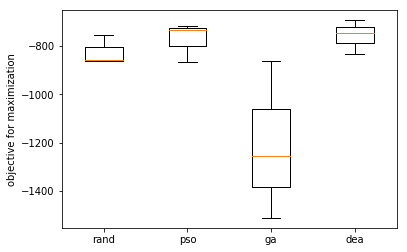

In [14]:
comp(options=['rand', 'pso', 'ga', 'dea'])

### Mountain Car

In [20]:
env = gym.make('MountainCar-v0')

print(env.action_space)
print(env.observation_space)
print(env.observation_space.high)
print(env.observation_space.low)

observation_len = 2
action_len = 3

mid_dim = 1
num_params = \
    observation_len * mid_dim + \
    mid_dim * action_len

population_size = 50
num_iterations = 50



WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
Discrete(3)
Box(2,)
[0.6  0.07]
[-1.2  -0.07]


In [16]:
random_run(render=True, trials=1)

Trial ended at 200 time steps


-200.0

In [17]:
def run_trial(weights):
    observation = env.reset()
    totalreward = 0
    while True:
        
        # transformation from optimization solution (rl agent) to action
        tmp = numpy.dot(observation, weights[0])
        tmp = list(numpy.dot(tmp, weights[1]))
        action = tmp.index(max(tmp))

        observation, reward, done, info = env.step(action)
        totalreward += reward
        if done:
            break
    return totalreward

def params2weights(parameters):
    assert len(parameters) == num_params
    weights = [
        numpy.zeros(shape=(observation_len, mid_dim)),
        numpy.zeros(shape=(mid_dim, action_len))
    ]
    index = 0
    for i in xrange(observation_len):
        for j in xrange(mid_dim):
            weights[0][i, j] = parameters[index]
            index += 1
    for i in xrange(mid_dim):
        for j in xrange(action_len):
            weights[1][i, j] = parameters[index]
            index += 1
    return weights

def objective_function(parameters):
    assert len(parameters) == num_params
    weights = params2weights(parameters)
    return run_trial(weights)


In [18]:
ea('dea')

#
# 2018-10-30 19:46:32.705930
#
# algorithm             = _DEAOptimizer
# timeout               = None
# max_iterations        = 25
# population_size       = 25
# crossover_probability = 0.5
# differential_weight   = 1.0
#
# POPULATION FOR GENERATION 1
# average_fitness = -200.0
# min_fitness     = -200.0
# max_fitness     = -200.0
#
# gen idv              fitness               param0               param1               param2               param3               param4
    1   1        -200.00000000           0.98218842           0.29012179           0.17618000           0.71500857           0.30252615
    1   2        -200.00000000           0.29991864           0.05133288           0.21043209           0.12046325           0.27765956
    1   3        -200.00000000           0.28120922           0.48026698           0.13754910           0.75179215           0.89529941
    1   4        -200.00000000           0.14395249           0.16213283           0.61124016           0.92835726     

#
# POPULATION FOR GENERATION 4
# average_fitness = -198.68
# min_fitness     = -200.0
# max_fitness     = -167.0
#
# gen idv              fitness               param0               param1               param2               param3               param4
    4   1        -167.00000000           0.00052015           0.50788693           0.18151043           0.32711269           1.07285421
    4   2        -200.00000000           0.98218842           0.29012179           0.17618000           0.71500857           0.30252615
    4   3        -200.00000000           0.29991864           0.05133288           0.21043209           0.12046325           0.27765956
    4   4        -200.00000000           0.28120922           0.48026698           0.13754910           0.75179215           0.89529941
    4   5        -200.00000000           0.14395249           0.16213283           0.61124016           0.92835726           0.77396824
    4   6        -200.00000000           0.00598088           0.1145

#
# POPULATION FOR GENERATION 7
# average_fitness = -198.68
# min_fitness     = -200.0
# max_fitness     = -167.0
#
# gen idv              fitness               param0               param1               param2               param3               param4
    7   1        -167.00000000           0.00052015           0.50788693           0.18151043           0.32711269           1.07285421
    7   2        -200.00000000           0.98218842           0.29012179           0.17618000           0.71500857           0.30252615
    7   3        -200.00000000           0.29991864           0.05133288           0.21043209           0.12046325           0.27765956
    7   4        -200.00000000           0.28120922           0.48026698           0.13754910           0.75179215           0.89529941
    7   5        -200.00000000           0.14395249           0.16213283           0.61124016           0.92835726           0.77396824
    7   6        -200.00000000           0.00598088           0.1145

#
# POPULATION FOR GENERATION 11
# average_fitness = -193.6
# min_fitness     = -200.0
# max_fitness     = -120.0
#
# gen idv              fitness               param0               param1               param2               param3               param4
   11   1        -120.00000000          -0.03053314           1.03909576          -0.05157012           0.19547749           0.87621646
   11   2        -156.00000000           0.00052015           0.50788693           0.18151043           0.23342958           0.54666917
   11   3        -164.00000000           0.00052015           0.50788693           0.62433009           0.32711269           1.07285421
   11   4        -200.00000000           0.98218842           0.29012179           0.17618000           0.71500857           0.30252615
   11   5        -200.00000000           0.29991864           0.05133288           0.21043209           0.12046325           0.27765956
   11   6        -200.00000000           0.28120922           0.4802

#
# POPULATION FOR GENERATION 15
# average_fitness = -193.6
# min_fitness     = -200.0
# max_fitness     = -120.0
#
# gen idv              fitness               param0               param1               param2               param3               param4
   15   1        -120.00000000          -0.03053314           1.03909576          -0.05157012           0.19547749           0.87621646
   15   2        -156.00000000           0.00052015           0.50788693           0.18151043           0.23342958           0.54666917
   15   3        -164.00000000           0.00052015           0.50788693           0.62433009           0.32711269           1.07285421
   15   4        -200.00000000           0.98218842           0.29012179           0.17618000           0.71500857           0.30252615
   15   5        -200.00000000           0.29991864           0.05133288           0.21043209           0.12046325           0.27765956
   15   6        -200.00000000           0.28120922           0.4802

#
# POPULATION FOR GENERATION 19
# average_fitness = -192.48
# min_fitness     = -200.0
# max_fitness     = -120.0
#
# gen idv              fitness               param0               param1               param2               param3               param4
   19   1        -120.00000000          -0.03053314           1.03909576          -0.05157012           0.19547749           0.87621646
   19   2        -156.00000000           0.00052015           0.50788693           0.18151043           0.23342958           0.54666917
   19   3        -160.00000000           0.00052015           0.50788693          -0.35429538           0.42878963           1.07285421
   19   4        -176.00000000           0.00598088           1.32763344           0.44466460           0.42878963           0.55448965
   19   5        -200.00000000           0.98218842           0.29012179           0.17618000           0.71500857           0.30252615
   19   6        -200.00000000           0.29991864           0.051

#
# POPULATION FOR GENERATION 23
# average_fitness = -189.56
# min_fitness     = -200.0
# max_fitness     = -90.0
#
# gen idv              fitness               param0               param1               param2               param3               param4
   23   1         -90.00000000           0.00052015           0.89773011           0.18151043           0.36805056           1.47778819
   23   2        -120.00000000          -0.03053314           1.03909576          -0.05157012           0.19547749           0.87621646
   23   3        -153.00000000           0.00052015           0.73486212          -0.35429538          -0.33412788           1.07285421
   23   4        -176.00000000           0.00598088           1.32763344           0.44466460           0.42878963           0.55448965
   23   5        -200.00000000           0.98218842           0.29012179           0.17618000           0.71500857           0.30252615
   23   6        -200.00000000           0.29991864           0.0513

-154.0

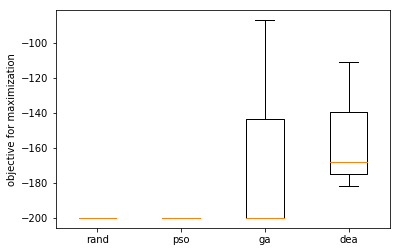

In [21]:
comp(options=['rand', 'pso', 'ga', 'dea'])